<h1 div class='alert alert-success'><center> TPS-Set: Feature Engineering</center></h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

# <div class="alert alert-success">  0. IMPORTAÇÕES </div>

In [1]:
import warnings
import random
import os
import gc
import shap

In [2]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection   import train_test_split
from sklearn.preprocessing     import QuantileTransformer
from sklearn.cluster           import KMeans
from yellowbrick.cluster       import KElbowVisualizer, SilhouetteVisualizer
from scipy.stats.mstats        import winsorize
from sklearn.decomposition     import PCA
from sklearn.impute            import SimpleImputer
from sklearn.metrics           import silhouette_samples, silhouette_score
from sklearn.model_selection   import train_test_split, KFold, RepeatedStratifiedKFold, StratifiedKFold  
from sklearn                   import metrics
from prettytable               import PrettyTable
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.tree              import DecisionTreeClassifier, export_graphviz

In [4]:
import xgboost                 as xgb

## 0.2. Funções

In [5]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    #warnings.filterwarnings(category=UserWarning)
    
    #pd.set_option('display.max_rows', 5)
    #pd.set_option('display.max_columns', 500)
    #pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    return icecream

icecream = jupyter_setting()

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
#warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [6]:
def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()

In [7]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
        
    return df

In [8]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.rcParams['font.size'] = 12
    plt.title('Precision Recall vs threshold')
    plt.xlabel('Threshold')
    plt.legend(loc="lower left")
    
    plt.grid(True)

In [9]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b-", label="Precision")
    
    plt.rcParams['font.size'] = 12
    plt.title('Precision vs recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # plt.legend(loc="lower left")
    
    plt.grid(True)

In [10]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('XGBR ROC curve for TPS 09')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

## 0.3. Carregar Dados

In [11]:
path = '/content/drive/MyDrive/kaggle/07. Tabular Playground Series - Ago 2021/'
path = '../input/tabular-playground-series-sep-2021/'
path = 'Data/'

In [12]:
df1_train     = pd.read_csv(path + 'train.csv', index_col='id')
df1_test      = pd.read_csv(path + 'test.csv',index_col='id')
df_submission = pd.read_csv(path + 'sample_solution.csv')

df1_train.shape, df1_test.shape, df_submission.shape

((957919, 119), (493474, 118), (493474, 2))

In [13]:
df1_test.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
957919,0.165850,0.487050,1295.00,0.02310,0.31900,0.90188,573.29,3743.7,2.705700e+12,6221.000,1.17200,5.175000e+09,0.25831,3.42050,0.044983,1001.600,10.1040,10.5360,19.517,-1.1209,1577.60,2.18470,96.109,1.1535,95.865,2.847100e+12,9.642100e+10,6406000.0,0.002990,6.6353,-0.015913,21723.0,67604.0,-0.000227,6.046200e+16,203.580,301.790,1.3461,5524.60,-0.003163,21.8830,0.027383,7.2113,24.82500,-0.001420,4.8950,-1.087100,7.0561,-1.061500,0.00010,1.85600,449.99,-0.36286,160.63,0.24801,0.62300,0.000116,-0.39384,1.9038,0.068588,0.020439,2.506500e+09,48.1640,-0.002272,78643.0,112.3600,1021.900,11.481,1.1573,0.002995,1.8192,1096.80,3.004100e+14,2.042300e+09,0.085500,4.6312,1683.10,9833.6,NaN,0.510410,4.0322,2.477900e+11,69.2640,5494800.0,1239.00,5.349300e+08,5.3086,182.590,829.17,5.2319,0.010301,3640.800,112.120,-0.43442,11.16100,3755.700,0.99926,5.338200e+10,1.3867,-0.001878,58.7940,75657.0,187.240,1258.90,0.163340,0.055398,0.020002,7.956400e+08,0.16253,-22.1890,2.0655,0.430880,-10.7410,81606.0,1.1940,1.980400e+14,2017.1,0.46357
957920,0.129650,0.373480,1763.00,0.72884,0.33247,-1.26310,875.55,554370.0,5.955700e+14,934.430,1.89790,4.905100e+09,0.28471,2.13870,-0.034328,35.223,6.5873,12.7340,29.590,4.1639,31915.00,3.11580,109.430,-0.8522,991.370,4.700100e+09,1.618200e+12,967810.0,1.021500,2.9617,0.810310,415570.0,384720.0,0.002243,6.712900e+15,228.590,33.952,1.4938,2067.50,-0.002343,32.7720,0.092283,6.5363,2.07730,0.046237,4.4590,-0.840920,4.4473,-1.001200,0.00375,99.64700,8146.80,22.50400,153.40,0.43076,0.74301,-0.000047,-0.11692,1.6544,0.467440,0.129650,4.442800e+08,38.5060,0.396220,74296.0,93.6290,-15.691,30.655,1.2311,1.004400,2.2484,780.87,1.213600e+14,3.488200e+11,-0.000792,6.9993,2451.60,10483.0,-5.3544,0.067286,5.4044,2.462600e+11,810.3000,860670.0,2165.20,2.711500e+08,10.2320,515.410,262.71,5.6357,0.374220,420.160,116.230,1.26980,0.78619,1207.000,1.00070,2.065000e+13,1.2888,0.248850,9.9857,16323.0,244.460,647.58,0.253820,0.008800,0.018479,1.120600e+08,0.81528,-1.6342,1.5736,-1.071200,11.8320,90114.0,1.1507,4.388000e+16,6638.9,0.28125
957921,0.120190,0.445210,736.26,0.04615,0.29605,0.31665,2659.50,317140.0,3.977800e+14,131.810,-0.48404,3.800000e+06,0.37173,0.40245,0.015119,1991.600,6.0050,0.9919,11.949,888.0700,887.70,3.52370,108.140,-1.6542,528.140,2.463600e+12,9.005900e+09,7259.3,1.007400,2.6123,1.062500,-208010.0,65708.0,0.001391,8.129800e+13,-84.032,NaN,1.7556,4729.20,0.003527,861.6600,0.902670,9.3934,58.78500,0.007244,5.6645,-0.627470,6.5806,-1.128200,0.38650,56.54700,125.36,12.70300,147.38,0.41437,0.51998,0.000857,-0.12065,5.4115,0.772530,0.128850,5.664900e+09,50.8940,0.378710,80045.0,65.2240,780.210,14.125,1.1657,-0.001285,1.0663,432.01,-5.953100e+11,1.383400e+12,-0.006236,5.6052,866.39,1065.2,-1.4805,0.064203,3.0197,1.684400e+11,212.8300,7891000.0,277.16,4.047900e+10,1.1170,393.510,8859.10,8.8098,0.405350,393.650,305.140,1.32660,30.85200,2803.700,0.99925,4.722600e+12,1.5003,0.493380,37.0470,139070.0,2464.000,4724.80,0.299160,0.093046,0.018516,6.519300e+07,0.81831,-32.7800,2.1364,-1.931200,-3.2804,37739.0,1.1548,1.718100e+14,5844.0,0.13797
957922,0.054008,0.395960,996.14,0.85934,0.36678,-0.17060,386.56,325680.0,-3.432200e+13,-26.473,-2.12930,4.675400e+09,0.26659,1.09680,-0.083571,1987.500,6.8989,11.1230,23.164,133.5700,-815.32,2.72950,82.011,3.8374,304.570,-1.315900e+10,-8.324500e+09,2297700.0,0.099522,4.9249,0.659900,48773.0,199560

In [14]:
df1_train = reduce_memory_usage(df1_train)
df1_test  = reduce_memory_usage(df1_test)

df1_train.shape, df1_test.shape

Mem. usage decreased to 265.84 Mb (69.7% reduction)
Mem. usage decreased to 136.48 Mb (69.5% reduction)


((957919, 119), (493474, 118))

In [ ]:
jb.dump(df1_train, 'df1_train')

# <div class="alert alert-success"> 1. Feature Engineering </div>

In [24]:
features_df = df1_train.columns.to_list()
features_df.remove('claim')

## 1.1. Step 01

A ideia de adicionar o recurso "n_missing" abaixo foi tirada deste [bloco notas](https://www.kaggle.com/maximkazantsev/tps-09-21-eda-lightgbm-with-folds) de por [BIZEN](https://www.kaggle.com/hiro5299834) .

In [25]:
df1_train['fe_n_missing'] = df1_train[features_df].isna().sum(axis=1)
df1_test['fe_n_missing']  = df1_test[features_df].isna().sum(axis=1)

df1_train.shape, df1_test.shape

((957919, 120), (493474, 119))

In [26]:
features_df.append('fe_n_missing')

## 2.1. Step 02 
Tratamento de valores faltantes, para os valores faltantes vamos imputar a mediana. 

In [27]:
imputer   = SimpleImputer(missing_values=np.nan, strategy='median')
df1_train = pd.DataFrame(imputer.fit_transform(df1_train), columns=df1_train.columns)
df1_test  = pd.DataFrame(imputer.fit_transform(df1_test),  columns=df1_test.columns)

In [28]:
missing_zero_values_table(df1_train)

Seu dataframe selecionado tem 120 colunas e 957919 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


In [29]:
missing_zero_values_table(df1_test)

Seu dataframe selecionado tem 119 colunas e 493474 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


## 2.3. Step 03
Aqui vamos criar duas variáveis que indica os valores estão próximo de zero ou não. 

In [30]:
df1_train['fe_f5_zero']  = (df1_train['f5'] < 0.02).astype(int)
df1_test['fe_f5_zero']   = (df1_test['f5'] < 0.02).astype(int)
df1_train['fe_f50_zero'] = (df1_train['f50'] < 0.02).astype(int)
df1_test['fe_f50_zero']  = (df1_test['f50'] < 0.02).astype(int)

Agora vamos criar algumas variáveis de estatística descritiva. 

In [32]:
df1_train['fe_mean']    = df1_train.mean(axis=1)
df1_test['fe_mean']     = df1_test.mean(axis=1)
df1_train['fe_median']  = df1_train.median(axis=1)
df1_test['fe_median']   = df1_test.median(axis=1)
df1_train['fe_std']     = df1_train.std(axis=1)
df1_test['fe_std']      = df1_test.std(axis=1)
df1_train['fe_min']     = df1_train.min(axis=1)
df1_test['fe_min']      = df1_test.min(axis=1)
df1_train['fe_max']     = df1_train.max(axis=1)
df1_test['fe_max']      = df1_test.max(axis=1)
df1_train['fe_skew']    = df1_train.skew(axis=1)
df1_test['fe_skew']     = df1_test.skew(axis=1)

df1_train.shape, df1_test.shape

((957919, 128), (493474, 127))

## 2.4. Step 04 
Neste step vamos criar uma nova variável com o algoritmo `kmeans`, para quem conhence o algoritmo vamos fazer uma clusterização, mas em primeiro lugar vamos criar algumas variáveis com uma PCD com as 40 principais componentes para a clusterização.

### 2.4.1. Scaler 

Vamos fazer o scaler dos datasets com o `QuatileTransforme` que teve melhor resultado na validação cruzada e no kaggle com AUC de 0.74479 com XGB, que se encontra no [notebook anterior](https://www.kaggle.com/rogeriodelfim/01-tps-set-ponto-de-partida-eda-e-linha-de-base?scriptVersionId=73995146).  

In [33]:
%%time
scaler        = QuantileTransformer(output_distribution='normal', random_state=0)
df1_train_qt  = df1_train.copy().drop('claim', axis=1) 
cols_quantile = df1_train_qt.columns
df1_train_qt  = pd.DataFrame(scaler.fit_transform(df1_train_qt), columns=cols_quantile)
df1_test_qt   = pd.DataFrame(scaler.fit_transform(df1_test), columns=cols_quantile )

Wall time: 45.7 s


### 2.4.2. Gerar PCA
Nesta etapa vamos criar 20 componente principal que serão serão utilizadas na clusterização, normalmente as primeiras componentes de uma PCA resumem a maior parte da variância dos dados, no caso desse conjunto de dados vamos precisamos de 20 à 40 compontes para termos uma melhor explicabilidade da variância dos dados.  

In [34]:
%%time
pca           = PCA(random_state=123)
df1_train_pca = pd.DataFrame(pca.fit_transform(df1_train_qt))

Wall time: 7.85 s


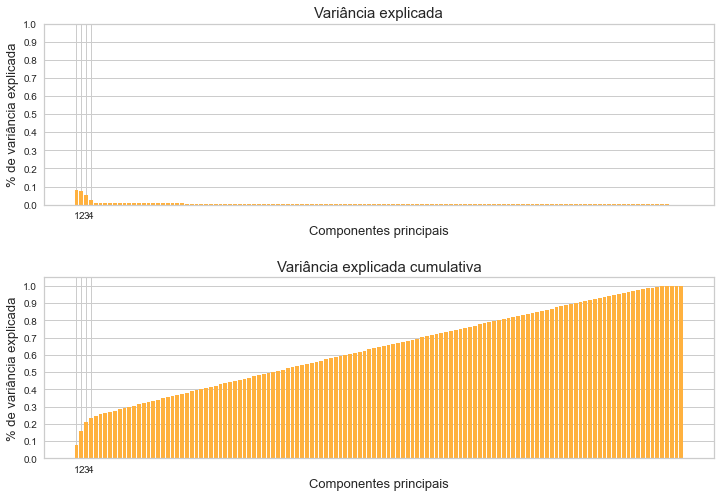

+------------+-----------------------+--------------------------------+
| Componente |  Variância explicada  | Variância explicada cumulativa |
+------------+-----------------------+--------------------------------+
|     1      |  0.07936398088448679  |      0.07936398088448679       |
|     2      |  0.07769648779528623  |      0.15706046867977302       |
|     3      |  0.05247548144003627  |       0.2095359501198093       |
|     4      |  0.025893925004446393 |       0.2354298751242557       |
|     5      |  0.01164641748667519  |       0.2470762926109309       |
|     6      |  0.008564754462973511 |       0.2556410470739044       |
|     7      |  0.007416136972220991 |       0.2630571840461254       |
|     8      |  0.007360740566667732 |       0.2704179246127931       |
|     9      |  0.007202398504416154 |       0.2776203231172093       |
|     10     | 0.0071712502220260925 |       0.2847915733392354       |
|     11     |  0.007119774501104958 |      0.29191134784034034 

In [35]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(wspace=.4, hspace=.4)

ax = fig.add_subplot(2, 1, 1)

ax.bar(range(1, 1+pca.n_components_),
       pca.explained_variance_ratio_,
       color='#FFB13F')

ax.set(xticks=[1, 2, 3, 4])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Variância explicada', fontsize=15)
plt.xlabel('Componentes principais', fontsize=13)
plt.ylabel('% de variância explicada', fontsize=13)

ax = fig.add_subplot(2, 1, 2)
ax.bar(range(1, 1+pca.n_components_),
       np.cumsum(pca.explained_variance_ratio_),
       color='#FFB13F')

ax.set(xticks=[1, 2, 3, 4])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Variância explicada cumulativa', fontsize=15)
plt.xlabel('Componentes principais', fontsize=13)
plt.ylabel('% de variância explicada', fontsize=13)
plt.show()

t = PrettyTable(['Componente',
                 'Variância explicada',
                 'Variância explicada cumulativa'])

principal_component = 1
cum_explained_var   = 0

for explained_var in pca.explained_variance_ratio_:
    cum_explained_var += explained_var
    t.add_row([principal_component, explained_var, cum_explained_var])
    principal_component += 1

print(t)

**`NOTA:`**

No primeiro gráfico observamos que os quatros primeiro compontes são pouco relevantes, com pouca explicabilidade, como podemos observar no segundo gráfico e na tabela de variância acumulada, sendo assim, vou selecionar 20 componeste para a clusterização, pois a explicabilidade chega à  35.45%.

In [36]:
n_components  = 20 
pca           = PCA(n_components=n_components, random_state=123)
pca_feats     = [f'feature_pca_{i}' for i in range(n_components)]
df1_train_pca = pd.DataFrame(pca.fit_transform(df1_train_qt), columns=pca_feats)
df1_test_pca  = pd.DataFrame(pca.fit_transform(df1_test_qt) , columns=pca_feats)

df1_train_pca.head()

,feature_pca_0,feature_pca_1,feature_pca_2,feature_pca_3,feature_pca_4,feature_pca_5,feature_pca_6,feature_pca_7,feature_pca_8,feature_pca_9,feature_pca_10,feature_pca_11,feature_pca_12,feature_pca_13,feature_pca_14,feature_pca_15,feature_pca_16,feature_pca_17,feature_pca_18,feature_pca_19
0,-1.201321,-1.225153,1.464130,-0.765775,-2.001419,-0.781431,-0.711500,0.951499,-0.199096,-0.493300,0.706417,0.097788,-0.149404,-0.489678,0.513572,1.495774,0.105053,0.601123,1.325714,0.633780
1,-1.320482,-1.419039,-3.622983,0.179211,-1.518451,-1.613655,0.661807,1.212870,0.782905,0.256358,-1.650197,2.123962,-0.087455,0.189753,-0.401726,-0.801874,-0.903875,-0.751179,0.260221,0.226010
2,-1.369659,-1.510758,2.819807,-4.024183,1.437131,0.496665,0.228546,-0.085420,-1.119523,0.727864,-0.367244,-1.460071,-0.400057,0.175578,1.674786,-3.205345,-0.030795,-0.117788,-0.641917,-0.928241
3,9.137447,-1.811831,1.869690,-3.352152,0.544484,1.180905,0.806815,0.080109,1.670777,0.548846,0.826737,0.391045,0.203888,-0.001879,1.971691,0.038188,-0.516648,-0.951563,1.006999,0.901696
4,-1.266770,-1.338862,3.967814,-1.538199,-0.694879,-0.560324,0.171174,-0.649582,-0.584217,0.084925,-0.181628,-0.395653,-0.455139,0.856909,-1.245117,-0.116585,0.726469,-1.130695,1.198612,1.238702


Pronto agora vamos para a próxima etapa que é gerar a variável de clusterização. 

### 2.1.2. Clusterização

Nesta etapa vamos cria uma nova variável com utilização do algoritmo `kmeams`, que tem a finalidade de criar clusters, vamos utilizar as variáveis criadas no processo anterior `2.4.2. Gerar PCA`.

In [37]:
df1_train  = df1_train.copy()
df1_test   = df1_test.copy()
df1_train.shape, df1_test.shape

((957919, 128), (493474, 127))

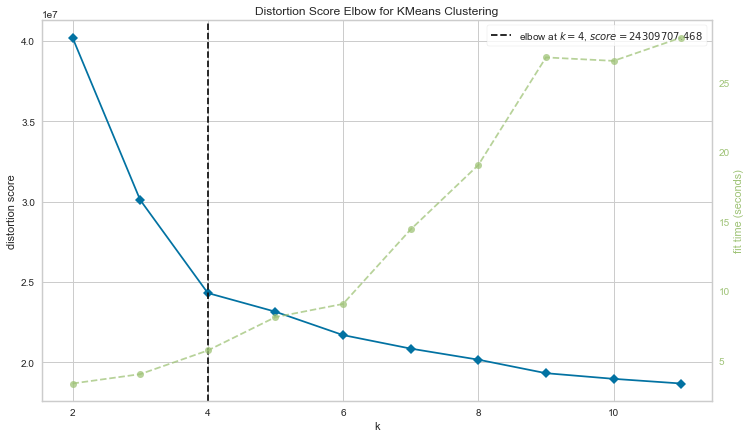

Wall time: 2min 31s


<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
%%time 
gc.collect()

plt.figure(figsize=(12, 7))
visualizer_1 = KElbowVisualizer(KMeans(random_state=59), k=(2,12))
visualizer_1.fit(df1_train_pca);
visualizer_1.poof();

Como podemos observar no gráfico acima, precisamos criar um modelo para clusterização de 4 clusters, então vamos fazer isso agora nos dados de treino e replicar para os dados de teste. 

In [39]:
gc.collect()

model_kmeans = KMeans(n_clusters=4, random_state=59)
model_kmeans.fit(df1_train_pca);

clusters_train = model_kmeans.predict(df1_train_pca)
clusters_test  = model_kmeans.predict(df1_test_pca)

df1_train['cluster'] = clusters_train
df1_test['cluster']  = clusters_test

df1_train.shape, df1_test.shape

((957919, 129), (493474, 128))

Vamos salvar os dataset, caso seja necessário refazer o processo podemos partir desse ponto. 

In [40]:
#!mkdir Data
#!mkdir Data/pkl
#!mkdir Data/sumbmission

In [41]:
jb.dump(df1_train,  "Data/pkl/df2_train.pkl.z")
jb.dump(df1_test,  "Data/pkl/df2_test.pkl.z")

['Data/pkl/df2_test.pkl.z']

In [43]:
gc.collect()

0

# <div class="alert alert-success"> 2. Split Train/Test </div>

In [44]:
df2_train = df1_train.copy()
df2_test  = df1_test.copy() 

In [45]:
X      = df2_train.drop(['claim'], axis=1)
y      = df2_train['claim']
cols   = X.columns
X_test = df2_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.1,
                                                      shuffle      = True, 
                                                      stratify     = y,
                                                      random_state = 0)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape 

((862127, 128), (862127,), (95792, 128), (95792,))

# <div class="alert alert-success"> 3. Modelagem </div>

Parametros do algoritmo

In [73]:
params = {'random_state': 0,          
          'predictor'   : 'gpu_predictor',
          'tree_method' : 'gpu_hist',
          'eval_metric' : 'auc'}

In [47]:
model_xgb = xgb.XGBClassifier(**params)
model_xgb.fit(X_train, y_train)

y_hat_prob = model_xgb.predict_proba(X_valid)[:, 1]
y_hat      = (y_hat_prob >.5).astype(int)

fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_hat_prob)
log_loss_     = metrics.log_loss(y_valid, y_hat_prob)                
f1_score_     = metrics.f1_score(y_valid, y_hat)        
auc_          = metrics.auc(fpr, tpr)    

print('AUC: {:.5f} - F1: {:.5f} - L. LOSS: {:.5f}'.format(auc_, f1_score_, log_loss_))
print('')

AUC: 0.81071 - F1: 0.79390 - L. LOSS: 0.51046



Obtivemos uma `AUC` de `0.81062`, isso que dizer que o acrescimo de novas variáveis nos dataset ajudou, porém precisams fazer uma validação mais robusta (validação cruzada) em vez de uma separação simples (Holdout), na validação cruzada vamos ter uma estimativa mais consistente.  

In [48]:
print(metrics.classification_report(y_valid, (y_hat_prob >.35).astype(int)))

              precision    recall  f1-score   support

         0.0       0.86      0.65      0.74     48040
         1.0       0.72      0.90      0.80     47752

    accuracy                           0.77     95792
   macro avg       0.79      0.77      0.77     95792
weighted avg       0.79      0.77      0.77     95792



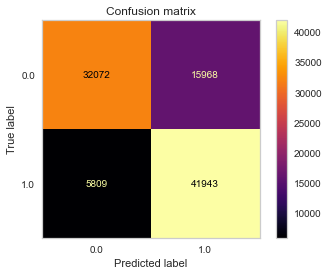

In [49]:
metrics.plot_confusion_matrix(model_xgb, X_valid, y_valid, cmap='inferno')
plt.title('Confusion matrix')
plt.grid(False)
plt.show()

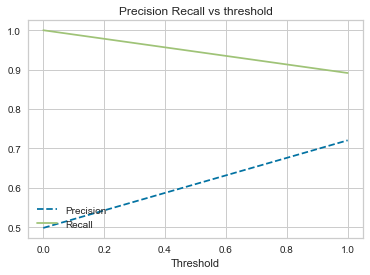

In [50]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_valid, (y_hat_prob >.45).astype(int))

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

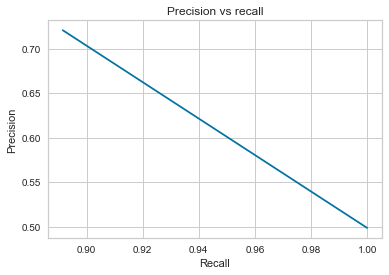

In [51]:
plot_precision_vs_recall(precisions, recalls)
plt.show()

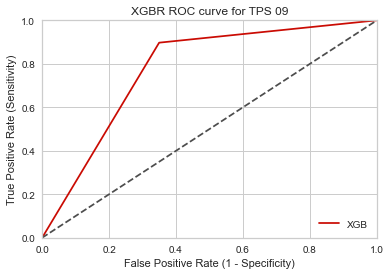

F1-score: 0.79390
F1-score: 0.79791 threshold(0.37)


In [52]:
threshold = .37
y_hat_threshold = (y_hat_prob>threshold).astype(int)
fpr, tpr, thresholds = metrics. roc_curve(y_valid, y_hat_threshold)

plot_roc_curve(fpr, tpr, label="XGB")
plt.show()

print('F1-score: {:2.5f}'.format(metrics.f1_score(y_valid, y_hat)))
print('F1-score: {:2.5f} threshold({:2.2f})'.format(metrics.f1_score(y_valid, y_hat_threshold), threshold))

## 4.1. Validação Cruzada

In [53]:
X_train     = df2_train.drop(['claim'], axis=1)
y_train     = df2_train['claim']

In [102]:
%%time

params = {'random_state': 0,          
          'predictor'   : 'gpu_predictor',
          'tree_method' : 'gpu_hist',
          'eval_metric' : 'auc'}

gc.collect()

X_train_oof_shap = np.zeros((X_train.shape[0],X_train.shape[1]+1))
feature          = X_test.columns.to_list()
scalers          = [#QuantileTransformer(output_distribution='uniform', random_state=0),
                    QuantileTransformer(output_distribution='normal' , random_state=0)]

feature.append('claim')

X_ts = pd.DataFrame(scaler.fit_transform(X_test.copy()), columns=X_test.columns)

SEED = 59 

gc.collect()

X_train_oof_shap = np.zeros((X_train.shape[0],X_train.shape[1]+2))
feature          = X_test.columns.to_list()
scalers          = [#QuantileTransformer(output_distribution='uniform', random_state=0),
                    QuantileTransformer(output_distribution='normal' , random_state=0)]

feature.append('claim')

Wall time: 15.7 s


In [117]:
%%time

for scaler in scalers: 

    FOLDS               = 5
    df_submission.claim = 0
    auc                 = []
    lloss               = []
    f1                  = []
    model_feature_imp   = 0 
    scale_distribution  = str.upper(scaler.get_params(True)['output_distribution']) 
    
    kfold               = KFold(n_splits = FOLDS, random_state = 0, shuffle = True)
 
    print('='*80)
    print('Scaler: {} => {}'.format(scaler, scale_distribution))
    print('='*80)

    cols_model_base = ['fe_f50_zero', 'fe_f5_zero', 'fe_n_missing', 'cluster', 
                       'fe_std', 'f105', 'f102', 'f22', 'f79', 'f106', 'f71', 
                       'f77', 'f69', #'f38','f57','f40', 'f1', 'f26', 'f82'
                      ]
    
    for i, (train_idx, test_idx) in enumerate(kfold.split(X_train)):

        i+=1
        
        X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_vl, y_vl = X_train.iloc[test_idx], y_train.iloc[test_idx]
        
        X_tr = pd.DataFrame(scaler.fit_transform(X_tr), columns=cols) 
        X_vl = pd.DataFrame(scaler.fit_transform(X_vl), columns=cols)                
        
        # # Treinar o modelo baseline
        model_base = xgb.XGBClassifier(**params)
        model_base.fit(X_tr[cols_model_base], y_tr)
        
        threshold = .5
        
        y_hat_prob_tr_mb = (model_base.predict_proba(X_tr[cols_model_base])[:, 1]>threshold).astype(int) 
        y_hat_prob_vl_mb = (model_base.predict_proba(X_vl[cols_model_base])[:, 1]>threshold).astype(int) 
        y_hat_prob_ts_mb = (model_base.predict_proba(X_ts[cols_model_base])[:, 1]>threshold).astype(int) 
        
        X_tr['fe_md_baseline'] = y_hat_prob_tr_mb 
        X_vl['fe_md_baseline'] = y_hat_prob_vl_mb
        X_ts['fe_md_baseline'] = y_hat_prob_ts_mb
        
        params_xgb = {#'n_estimators'    : 500,
                      'max_depth'        : 7,
                      'min_child_weight' : 40,
                      'subsample'        : 0.662776837991846,
                      'colsample_bynode' : 0.7392362752914446,
                      'learning_rate'    : 0.18833941612449953,
                      'colsample_bytree' : 0.6094875461582554,
                      'reg_lambda'       : 10,
                      'reg_alpha'        : 42,
                      'eta'              : 0.07162137592923906,
                      'alpha'            : 0.5197749697495789}

        # Treinar XGB com a variável fe_md_baseline 
        model = xgb.XGBClassifier(**params_xgb, 
                                  objective         = 'binary:logistic',                  
                                  predictor         = 'gpu_predictor',
                                  tree_method       = 'gpu_hist',
                                  eval_metric       = 'auc', 
                                  random_state      = 59 
                                 ) 

        model.fit(X_tr, y_tr)

        y_hat_prob = model.predict_proba(X_vl)[:, 1]
        y_hat      = (y_hat_prob >.5).astype(int) 
        
        fpr, tpr, thresholds = metrics.roc_curve(y_vl, y_hat_prob)
                 
        log_loss_     = metrics.log_loss(y_vl, y_hat_prob)                
        f1_score_     = metrics.f1_score(y_vl, y_hat)        
        auc_          = metrics.auc(fpr, tpr)    
                
        msg = '[Fold {}] AUC: {:.5f} - F1: {:.5f} - L. LOSS: {:.5f}'
        print(msg.format(i, auc_, f1_score_, log_loss_))

        df_submission.claim += model.predict_proba(X_ts)[:, 1]/FOLDS
        model_feature_imp   += model.feature_importances_/ FOLDS
        
        X_train_oof_shap[test_idx,:] = np.hstack([X_vl , y_hat.reshape(-1, 1)])
                
        f1.append(f1_score_)
        lloss.append(log_loss_)
        auc.append(auc_)
        
    auc_mean   = np.mean(auc)
    auc_std    = np.std(auc)
    lloss_mean = np.mean(lloss)
    f1_mean    = np.mean(f1)
    
    print('-'*80)
    msg = '[Mean Fold] AUC: {:.5f}(Std:{:.5f}) - F1: {:.5f} - L. LOSS: {:.5f}'
    print(msg.format(auc_mean, auc_std, f1_mean, lloss_mean))
    print('='*80)
    print('')
    
    # Gerar o arquivo de submissão 
    name_file_subm = str(scaler).lower()[:4] + '_' + scale_distribution 
    name_file_subm = 'Data/sumbmission/001_xgb_feature_engineering_' + name_file_subm + '.csv'
    
    df_submission.to_csv(name_file_subm, index=False)
    
    gc.collect()

Scaler: QuantileTransformer(output_distribution='normal', random_state=0) => NORMAL
[Fold 1] AUC: 0.81276 - F1: 0.79421 - L. LOSS: 0.51012
[Fold 2] AUC: 0.76507 - F1: 0.73254 - L. LOSS: 0.60219
[Fold 3] AUC: 0.78500 - F1: 0.74433 - L. LOSS: 0.57829
[Fold 4] AUC: 0.78205 - F1: 0.73746 - L. LOSS: 0.58555
[Fold 5] AUC: 0.81193 - F1: 0.79410 - L. LOSS: 0.50994
--------------------------------------------------------------------------------
[Mean Fold] AUC: 0.79136(Std:0.01844) - F1: 0.76053 - L. LOSS: 0.55722

Wall time: 9min 17s


In [ ]:
# ================================================================================
# Scaler: QuantileTransformer(0.80883) => NORMAL
# ================================================================================
# [Fold 1] AUC: 0.81276 - F1: 0.79421 - L. LOSS: 0.51012
# [Fold 2] AUC: 0.76507 - F1: 0.73254 - L. LOSS: 0.60219
# [Fold 3] AUC: 0.78500 - F1: 0.74433 - L. LOSS: 0.57829
# [Fold 4] AUC: 0.78205 - F1: 0.73746 - L. LOSS: 0.58555
# [Fold 5] AUC: 0.81193 - F1: 0.79410 - L. LOSS: 0.50994
# --------------------------------------------------------------------------------
# [Mean Fold] AUC: 0.79136(Std:0.01844) - F1: 0.76053 - L. LOSS: 0.55722
# ================================================================================
# 
# Wall time: 6min 1s

<div class="alert alert-info" role="alert">
    
**`NOTA:`**

Como podemos obsevar acima, a média de AUC na validação cruzada foi de 0.78552 e na submissão do kaggle foi uma AUC de 0.80771, sem ajustes nos parametros do XGB.  

## 4.2. Feature importances

Nesta etapa vamos utilizar duas formas de verificar a importância das variáveis para o modelo: 
- As feature importance (feature_importances_) do próprio modelo 
- Shap

### 4.2.1. Feature_importances_ 

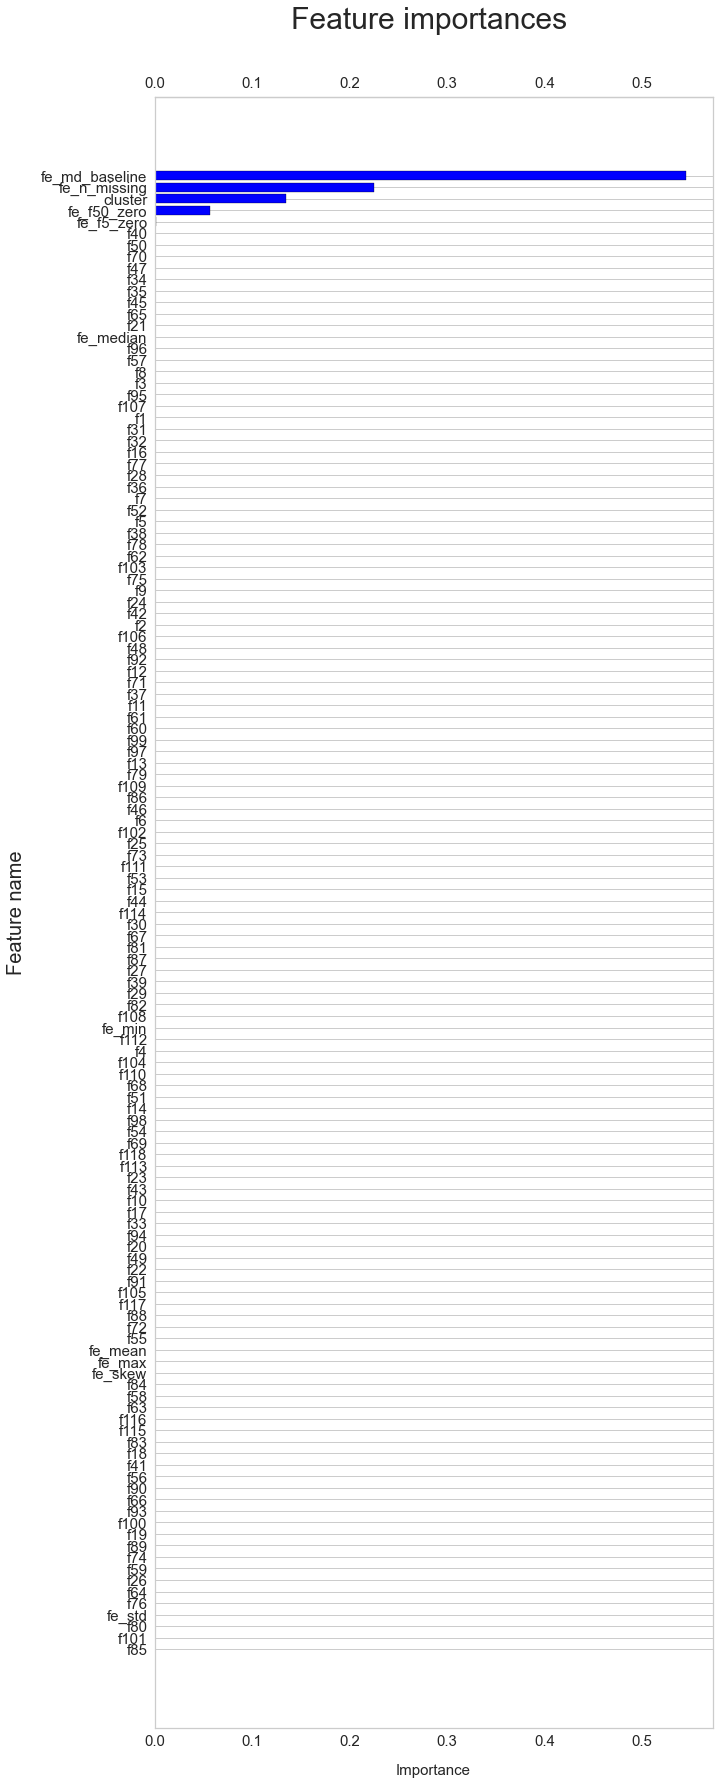

In [189]:
cols_feature    = X.columns.to_list()
cols_feature.append('fe_md_baseline')

df               = pd.DataFrame()
df["Feature"]    = cols_feature
df["Importance"] = model_feature_imp / model_feature_imp.sum()

df.sort_values("Importance", axis=0, ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10, 30))
bars = ax.barh(df["Feature"], df["Importance"], 
               height    = 0.8,
               color     = "blue",  # mediumorchid
               edgecolor = "black")

ax.set_title("Feature importances \n", fontsize=30, pad=15)
ax.set_ylabel("Feature name", fontsize=20, labelpad=15)
ax.set_xlabel("Importance", fontsize=15, labelpad=15)
ax.set_yticks(df["Feature"])
ax.set_yticklabels(df["Feature"], fontsize=15)
ax.tick_params(axis="x", labelsize=15)
ax.grid(axis="x")

# Adding labels on top
ax2 = ax.secondary_xaxis('top')
#ax2.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax2.tick_params(axis="x", labelsize=15)

# Inverting y axis direction so the values are decreasing
plt.gca().invert_yaxis()

Acima podemos observar que algumas das variáveis que criamos estão entre as 25 variáveis mais importantes para o modelo, porém não gosto muito de jeito de analisar a importância das variáveis, vamos utilizar o `Shap` que utilza vários métodos diferentes para encontrar as variáveis importantes. 

## Shap

SHAP (SHapley Additive exPlanations) é uma abordagem teórica de jogos para explicar a saída de qualquer modelo de aprendizado de máquina, ver o  [artigos](https://github.com/slundberg/shap#citations) para detalhes e citações.

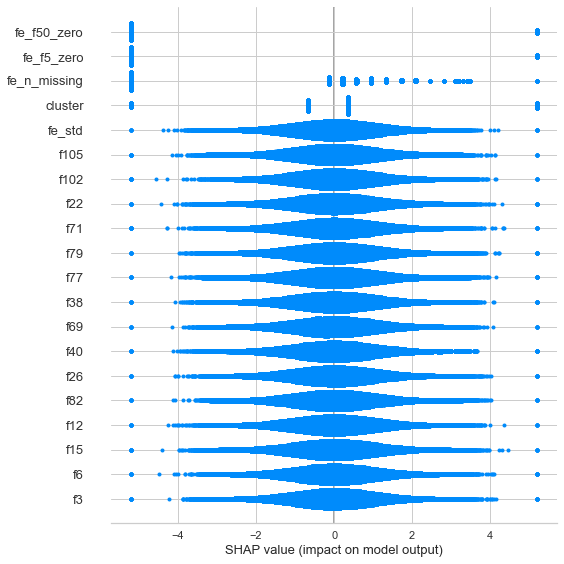

In [153]:
# resumir os efeitos de todos os recursos
shap.summary_plot(X_train_oof_shap[:,:-1], cols_feature,)

Como podemo observar a ordem das variáveis importantes para o modelo mudarão, agora temos as 4 primeira variáveis que foram criadas como principais, no notebook de feature select vou utilizar o `Shap` para analise da seleção das variáveis. 

Vamos salvar o dataset para o próximo notebook, que será a tunagem de parametros. 

In [154]:
jb.dump(df2_train,  "Data/pkl/df3_train.pkl.z")
jb.dump(df2_test,  "Data/pkl/df3_test.pkl.z")

gc.collect()

28535

- 